# HySwash: A hybrid method for nearshore wave processes

![sketch](./assets/hyswash-sketch.png)

## 1. Variables Selection

It is essential to carefully select the variables that will feed into the presented metamodel. The numerical model SWASH (Simulating WAves till SHore) is designed to solve the Navier-Stokes equations numerically, relying on key hydrodynamic input variables. Drawing from previous research on hydrodynamic modeling, it has been proven that the necessary variables encompass :
- Significant wave height (Hs)
- Wave slope (Hs/L0)
- VegetationHeight

However, when it comes to simulating the complex process of wave breaking in the nearshore zone, SWASH requires additional inputs to accurately reflect real-world conditions. The model alone cannot determine these parameters, necessitating user-defined inputs. Therefore, we also include the two critical coefficients responsible for governing wave breaking and energy dissipation: 
- Seabed friction coefficient (Cf)

Proper calibration of these coefficients is crucial for the model to realistically simulate wave behavior and energy dissipation in coral reef environments.

In [1]:
variables_to_analyse_in_metamodel = ["Hs", "Hs_L0", "VegetationHeight"]
default_parameters_to_numerical_model = {
    "tendc": 600,  # Time of simulation
    "warmup": 600,  # Time of warmup
    "np_ini": 800,  # Vegetation start cell (must be > 800 and < np_fin)
    "np_fin": 900,  # Vegetation end cell (must be > np_ini and < 1100)
    "cf": 0.01,  # Friction manning coefficient (m^-1/3 s)
}

![profile](./assets/hyswash-profile.png)

## 2. Sampling and Selection

The first step in implementing our metamodel involves generating and selecting specific representative cases that combine the variables previously identified. These combinations will accurately simulate realistic sea states in SWASH. Therefore, our task is to create realistic combinations of these variables to feed into the numerical model later on.

### 2.1. Latin Hypercube Sampling (LHS)

The Latin Hypercube Sampling (LHS) is a statistical technique designed to efficiently select parameter values across multiple dimensions while ensuring controlled randomness in the sampled data. To implement this technique, we start by establishing the limits for each variable.

In [2]:
from bluemath_tk.datamining.lhs import LHS

lhs_parameters = {
    "num_dimensions": 3,
    "num_samples": 10000,
    "dimensions_names": variables_to_analyse_in_metamodel,
    "lower_bounds": [0.5, 0.005, 0],
    "upper_bounds": [3, 0.05, 1.5],
}

lhs = LHS(
    num_dimensions=lhs_parameters.get("num_dimensions"),
)
df_dataset = lhs.generate(
    dimensions_names=lhs_parameters.get("dimensions_names"),
    lower_bounds=lhs_parameters.get("lower_bounds"),
    upper_bounds=lhs_parameters.get("upper_bounds"),
    num_samples=lhs_parameters.get("num_samples"),
)

### 2.2 Maximum Dissimilarity Algorithm (MDA)

The high computational cost of propagating the entire hindcast dataset requires statistical tools to reduce the set of data to a number of representative cases to perform hybrid downscaling. The maximum dissimilarity algorithm (MDA) defined in the work of Camus et al., 2011, is implemented for this purpose.<br>
    <br>
Given a data sample $X=\{x_{1},x_{2},…,x_{N}\}$ consisting of $N$ $n$-dimensional vectors, a subset of $M$ vectors $\{v_{1},…,v_{M}\}$ representing the diversity of the data is obtained by applying this algorithm. The selection starts initializing the subset by transferring one vector from the data sample ${v_{1}}$. The rest of the $M-1$ elements are selected iteratively, calculating the dissimilarity between each remaining data in the database and the elements of the subset and transferring the most dissimilar one to the subset. The process finishes when the algorithm reaches $M$ iterations.

2025-02-11 16:48:47,303 - MDA - INFO - Using max calculated value seed=5535 as first centroid.
2025-02-11 16:48:47,305 - MDA - INFO -    MDA centroids: 2/5
2025-02-11 16:48:47,306 - MDA - INFO -    MDA centroids: 3/5
2025-02-11 16:48:47,307 - MDA - INFO -    MDA centroids: 4/5
2025-02-11 16:48:47,308 - MDA - INFO -    MDA centroids: 5/5


(<Figure size 640x480 with 3 Axes>,
 array([[<Axes: xlabel='Hs_L0', ylabel='Hs'>, <Axes: >],
        [<Axes: >, <Axes: xlabel='VegetationHeight', ylabel='Hs_L0'>]],
       dtype=object))

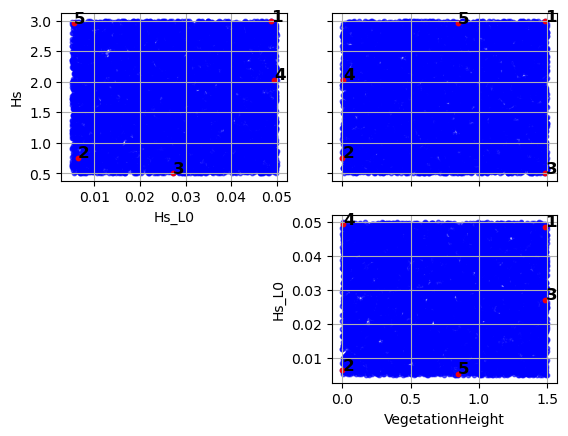

In [3]:
from bluemath_tk.datamining.mda import MDA

mda_parameters = {"num_centers": 5}

mda = MDA(num_centers=mda_parameters.get("num_centers"))
mda.fit(data=df_dataset)
mda.plot_selected_centroids()

## 3. Numerical model SWASH

Once the hydrodynamic cases to be numerically simulated have been selected through the MDA algorithm, we proceed to launch these cases in SWASH. It is a versatile numerical tool designed to simulate a non-hydrostatic, phase-resolving wave model capable of simulating waves from deep waters to the shoreline, modeling wave breaking, bottom friction, wave- induced setup and runup, and the generation and propagation of infragravity waves (Delft University of Technology, n. d.).

In [4]:
import os
from bluemath_tk.wrappers.swash.swash_example import VeggySwashModelWrapper

# Define the input parameters
templates_dir = os.path.join(os.getcwd(), "templates")
# Get the centroids
model_parameters = mda.centroids.to_dict(orient="list")
output_dir = "/home/tausiaj/GitHub-GeoOcean/swash/cases/"
# Create an instance of the SWASH model wrapper
swash_model = VeggySwashModelWrapper(
    templates_dir=templates_dir,
    model_parameters=model_parameters,
    output_dir=output_dir,
)

2025-02-11 16:48:47,804 - VeggySwashModelWrapper - WARNING - Parameter Hs is not in the default_parameters
2025-02-11 16:48:47,805 - VeggySwashModelWrapper - WARNING - Parameter Hs_L0 is not in the default_parameters
2025-02-11 16:48:47,805 - VeggySwashModelWrapper - WARNING - Parameter VegetationHeight is not in the default_parameters
2025-02-11 16:48:47,806 - VeggySwashModelWrapper - WARNING - Templates name is 'all', so all templates in /home/tausiaj/GitHub-GeoOcean/swash/templates will be used.
2025-02-11 16:48:47,806 - VeggySwashModelWrapper - INFO - Templates names: ['depth.bot', 'input.sws', 'plants.txt']


In [5]:
# Build the input files
swash_model.build_cases(mode="one_by_one")

2025-02-11 16:48:49,068 - VeggySwashModelWrapper - INFO - 5 cases created in one_by_one mode and saved in /home/tausiaj/GitHub-GeoOcean/swash/cases/


In [8]:
# Run the model
swash_model.run_cases(launcher="docker", parallel=True)

2025-02-11 16:50:39,115 - VeggySwashModelWrapper - DEBUG - Running cases in parallel with launcher=docker run --rm -v .:/case_dir -w /case_dir tausiaj/swash-geoocean:11.01 swashrun -input input.sws. Number of threads: 20.
2025-02-11 16:50:39,116 - VeggySwashModelWrapper - INFO - Running case in /home/tausiaj/GitHub-GeoOcean/swash/cases/0000 with launcher=docker run --rm -v .:/case_dir -w /case_dir tausiaj/swash-geoocean:11.01 swashrun -input input.sws.
2025-02-11 16:50:39,116 - VeggySwashModelWrapper - INFO - Running case in /home/tausiaj/GitHub-GeoOcean/swash/cases/0001 with launcher=docker run --rm -v .:/case_dir -w /case_dir tausiaj/swash-geoocean:11.01 swashrun -input input.sws.
2025-02-11 16:50:39,118 - VeggySwashModelWrapper - INFO - Running case in /home/tausiaj/GitHub-GeoOcean/swash/cases/0002 with launcher=docker run --rm -v .:/case_dir -w /case_dir tausiaj/swash-geoocean:11.01 swashrun -input input.sws.
2025-02-11 16:50:39,118 - VeggySwashModelWrapper - INFO - Running case in

## 4. Data Processing

The primary output variable generated by SWASH include the time series of water level along the profile. This output serves as crucial indicator of the hydrodynamic processes impacting the reef. From this SWASH output, we compute various other key variables. Different output quantities will be given here to go over the different wave transformation processes including wave propagation, dispersion, flooding and drying, moving shoreline, surf-beat, infragravity waves, set-up induced by wave breaking, run-up and overtopping discharge. 

- To this end, the time-dependent surface elevation is stored at every grid point for every time step. After removing the warmup time from the sea surface series, a FFt is applied to obtain its representation in the frequency domain. A further classification is given by spliting the wave frequency into incident waves IC (0.04 - 1), infragravity waves IG (0.004 - 0.04) and very low frequency VLF (0.001 - 0.004). 

- The run-up heigh is computed by the intersection between free surface and bottom level considering a minimun  depth of 1cm after each time step. 

- The mean wave overtopping discharge q (ms/l) is outputted at the highest elevation point.

In [7]:
import warnings

warnings.filterwarnings("ignore")

# convert raw SWASH output to netcdf files (if output.nc NOT in case folder)
postprocessed_output = swash_model.postprocess_cases()

2025-02-11 16:49:38,811 - VeggySwashModelWrapper - INFO - Postprocessing case 0 in /home/tausiaj/GitHub-GeoOcean/swash/cases/0000.
2025-02-11 16:49:38,812 - VeggySwashModelWrapper - INFO - Postprocessing all available variables.
2025-02-11 16:49:46,382 - VeggySwashModelWrapper - INFO - Postprocessing case 1 in /home/tausiaj/GitHub-GeoOcean/swash/cases/0001.
2025-02-11 16:49:46,382 - VeggySwashModelWrapper - INFO - Postprocessing all available variables.


FileNotFoundError: [Errno 2] No such file or directory: '/home/tausiaj/GitHub-GeoOcean/swash/cases/0001/output.tab'

In [ ]:
postprocessed_output

<xarray.Dataset> Size: 239MB
Dimensions:   (Tsec: 1418, Xp: 1400, case_num: 15)
Coordinates:
  * Tsec      (Tsec) float64 11kB 0.0 1.011 2.008 ... 1.199e+03 1.199e+03
  * Xp        (Xp) float64 11kB 0.0 1.0 2.0 ... 1.397e+03 1.398e+03 1.399e+03
  * case_num  (case_num) int64 120B 0 1 2 3 4 0 5 1 6 2 7 3 8 4 9
    Yp        float64 8B 0.0
Data variables:
    Ru2       (case_num) float64 120B 1.347 0.6994 0.1481 ... 0.8103 nan 1.643
    Runlev    (case_num, Tsec) float64 170kB 0.0 0.0 0.0 ... 0.9163 0.9723 nan
    Msetup    (case_num, Xp) float64 168kB 0.02184 0.007059 ... 3.581 3.58
    Hrms      (case_num, Xp) float64 168kB nan nan nan nan ... nan nan nan nan
    Hs        (case_num, Xp) float64 168kB nan nan nan ... 0.0 4.865e-15
    Hss       (case_num, Xp) float64 168kB nan nan nan ... 0.0 1.765e-18
    ig        (case_num, Xp) float64 168kB nan nan nan ... 0.0 4.865e-15
    Hvlf      (case_num, Xp) float64 168kB nan nan nan ... 0.0 4.554e-15
    Watlev    (case_num, Xp, Tsec) float64 238MB 0.0 -0.6808 0.7039 ... 3.58 nan

### Numerical Cases Visualization

In [ ]:
g = postprocessed_output.Hs.isel(Xp=slice(0, 1150)).plot(col="case_num", col_wrap=5)
g.fig.subplots_adjust(hspace=0.15, wspace=0.15)
for ax, case_num in zip(g.axes.flatten(), postprocessed_output["case_num"].values):
    ax.set_title(
        f"Hs: {mda.centroids.Hs.values[int(case_num)]:.2f} | Vegetation: {mda.centroids.VegetationHeight.values[int(case_num)]:.2f}"
    )
    # Remove the spines (edges)
    for spine in ax.spines.values():
        spine.set_visible(False)
    # Retain the grid (set grid on)
    ax.grid(True)

ValueError: Coordinates used for faceting cannot contain repeated (nonunique) values.

### Total Water Elevation Visualization

In [ ]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML

depth = np.loadtxt("/home/tausiaj/GitHub-GeoOcean/swash/templates/depth.bot")


def animate_case_propagation(case_dataset, tini=0, tend=30, tstep=2, figsize=(15, 5)):
    """
    Function to animate the propagation of the swash for a single case
    """

    fig, ax = plt.subplots(1, figsize=figsize)

    # Init animation
    def init():
        return []

    # Función de actualización de la animación
    def update(frame):
        ax.clear()

        ax.tick_params(axis="both", which="major", labelsize=12)
        ax.set_xlim(400, 1250)
        ax.set_ylim(-4, 2)
        ax.set_xlabel("Cross-shore Distance (m)", fontsize=12)
        ax.set_ylabel("Elevation (m)", fontsize=12)

        # bathymetry
        ax.fill_between(
            np.arange(len(depth)),
            np.ones(len(depth)) * depth[-1],
            -depth,
            fc="wheat",
            zorder=2,
        )

        # waves
        elev = case_dataset.isel(Tsec=frame)["Watlev"].values
        ax.fill_between(
            np.arange(len(depth)),
            np.ones(len(depth)) * depth[-1],
            elev,
            fc="deepskyblue",
            alpha=0.5,
            zorder=1,
        )
        ax.set_title("Time : {0} s".format(frame), fontsize=12)

        return []

    # Crear animación
    ani = animation.FuncAnimation(
        fig, update, frames=np.arange(tini, tend, tstep), init_func=init, blit=True
    )
    plt.close()

    # Mostrar animación
    return ani

In [ ]:
ani = animate_case_propagation(
    postprocessed_output.isel(case_num=0), tini=50, tend=300, tstep=4, figsize=(15, 5)
)
HTML(ani.to_jshtml())

## 5. Reconstruction: Principal Component Analysis (PCA) & Radial Basis Fucntions (RBF)

The reconstruction of the time series of wave parameters in the position of the buoy is carried out by an interpolation technique based on radial basis functions (RBF), a scheme wich is very convenient for scatter and multivariate data. The RBF approximation has been applied successfully in many fields, usually with better results than other interpolation methods (Hardy, 1990).
    
Suppose that $f=f(x)$ is the real-valued function that we want to approximate. We are given M scattered data points $\{x_1,..., x_M\}$ of dimension $\textit{n}$ and the associated real function values $\{f_1, ..., f_M\}$, being $f_i = f(x_j), j = 1,...,M$. The RBF interpolation method consists of a weighted sum of radially symmetric basic functions located at the data points. The approximation function is assumed to be of the form:
$$RBF(x) = p(x) + \sum\limits_{j=1}^M a_j\Phi{\large (}{\large \parallel}{x - x_j}{\large \parallel}{\large )}$$

In [ ]:
import ipywidgets as widgets
import pandas as pd
import xarray as xr
from bluemath_tk.datamining.pca import PCA
from bluemath_tk.interpolation.rbf import RBF
from ipywidgets import interact


def show_graph_for_different_parameters():
    """
    Show graph for different parameters
    """

    # Function to update the plot based on widget input
    def update_plot(hs=1.5, hs_l0=0.02, vegetation=1):
        # Create dataframe
        df_dataset_single_case = pd.DataFrame(
            data={
                "Hs": [hs],
                "Hs_L0": [hs_l0],
                "VegetationHeight": [vegetation],
            }
        )

        # Spatial Reconstruction
        pca = PCA()
        pcs = pca.fit_transform(
            data=postprocessed_output,
            vars_to_stack=["Hs"],
            coords_to_stack=["Xp"],
            pca_dim_for_rows="case_num",
        )
        pcs_df = pd.DataFrame(
            pcs.PCs, columns=[f"PC{i + 1}" for i in range(len(pcs.PCs.n_component))]
        )

        # Apply RBF recosntruction
        rbf = RBF()
        predicted_hs = rbf.fit_predict(
            subset_data=mda.centroids,
            target_data=pcs_df,
            dataset=df_dataset_single_case,
        )
        predicted_hs_ds = xr.Dataset(
            {
                "PCs": (["case_num", "n_component"], predicted_hs.values),
            },
            coords={"case_num": [0], "n_component": np.arange(len(pcs.PCs.n_component))},
        )

        # Get reconstructed Hs
        ds_output_all = pca.inverse_transform(PCs=predicted_hs_ds)

        fig, ax = plt.subplots(figsize=(14, 6))
        ds_output_all["Hs"].sel(case_num=0).plot(x="Xp", ax=ax, color="k")
        # sm.plot_depthfile(ax=ax)
        # ax.plot(
        #     np.arange(int(pp.swash_proj.np_ini), int(pp.swash_proj.np_fin)),
        #     np.repeat(-2.5, int(pp.swash_proj.np_fin - pp.swash_proj.np_ini)),
        #     color="darkgreen",
        #     linewidth=int(25 * vegetation),
        # )
        ax.set_ylim(-7, 4)
        ax.set_xlim(400, 1160)
        ax.grid(True)

        ax.set_title(
            f"Reconstructed Hs for Hs: {hs}, Hs_L0: {hs_l0} and VegetationHeight: {vegetation}"
        )

    # Creating widgets
    widget_hs = widgets.FloatSlider(
        value=1.5, min=0.5, max=3, step=0.5, description="Hs:"
    )
    widget_hs_l0 = widgets.FloatSlider(
        value=0.02, min=0.01, max=0.03, step=0.01, description="Hs_L0:"
    )
    widget_vegetation = widgets.FloatSlider(
        value=1, min=0, max=1.5, step=0.5, description="VegetationHeight:"
    )

    # Using interact to link widgets to the function
    return interact(
        update_plot, hs=widget_hs, hs_l0=widget_hs_l0, vegetation=widget_vegetation
    )

In [ ]:
# Re-execute cell if first run raises error
show_graph_for_different_parameters()

interactive(children=(FloatSlider(value=1.5, description='Hs:', max=3.0, min=0.5, step=0.5), FloatSlider(value…

<function __main__.show_graph_for_different_parameters.<locals>.update_plot(hs=1.5, hs_l0=0.02, vegetation=1)>